In [67]:
import sys
sys.path.append('..\\helpers')

import cv2
import random
import os
import matplotlib.pyplot as plt
import numpy as np
from loguru import logger
import pandas as pd
import seaborn as sns
from PIL import Image, ImageDraw

plt.rcParams['figure.figsize'] = (20, 18)
plt.style.use('classic')
plt.subplots_adjust(wspace=0, hspace=0)
sns.set()

# To allow auto reload to this notebook after modifying any external file imported
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<Figure size 640x480 with 0 Axes>

## Exploratory Data Analysis

Understanding data structure and setting global variables

In [6]:
dataset_folder_paths = [(x[0].split("\\")[-1], x[0]) for x in os.walk("..\\dataset")][1:]
dataset_folder_paths

[('groundtruth', '..\\dataset\\groundtruth'),
 ('images', '..\\dataset\\images'),
 ('masks', '..\\dataset\\masks'),
 ('overlay', '..\\dataset\\overlay')]

Preparing a dataframe to summarize the dataset

In [10]:
positive_labelled_images = []
negative_labelled_images = []

dataset = []

labels = ["positives", "negatives"]

for idx, object in enumerate(labels):
        with open(f'..\\dataset\\{str(object)}.txt') as f:
            lines = f.read().splitlines()
            
            for line in lines:
                if line != "":
                    new_path = os.path.join(dataset_folder_paths[1][1], line)
                    
                    dataset.append((str(object), line))
                    positive_labelled_images.append(new_path) if str(object) == 'positives' else negative_labelled_images.append(new_path)

dataset_df = pd.DataFrame(dataset, columns=['class', 'filename'])
dataset_df.sample(10)

,class,filename
360,negatives,53580979_4c341dad22471922_MG_L_ML_ANON.tif
242,negatives,50993643_b03f1dd34eb3c55f_MG_L_CC_ANON.tif
124,negatives,20587836_81cd83d2f4d78528_MG_R_CC_ANON.tif
206,negatives,24055958_839819f2eadaf325_MG_R_CC_ANON.tif
388,negatives,53582818_465aa5ec1b59efc6_MG_R_CC_ANON.tif
284,negatives,50996709_330e5fe16929eed4_MG_R_ML_ANON.tif
283,negatives,50996379_6aba0b402889a16f_MG_L_CC_ANON.tif
33,positives,22580706_fe7d005dcbbfb46d_MG_R_ML_ANON.tif
43,positives,22614379_d065adcb9905b973_MG_L_CC_ANON.tif
14,positives,20588308_493155e17143edef_MG_L_ML_ANON.tif


Dataset Summary

In [11]:
dataset_df.describe()

,class,filename
count,410,410
unique,2,410
top,negatives,20586908_6c613a14b80a8591_MG_R_CC_ANON.tif
freq,303,1


In [12]:
# Checking if we have duplicate files, all good!
len(dataset_df["filename"].unique())

410

<Axes: >

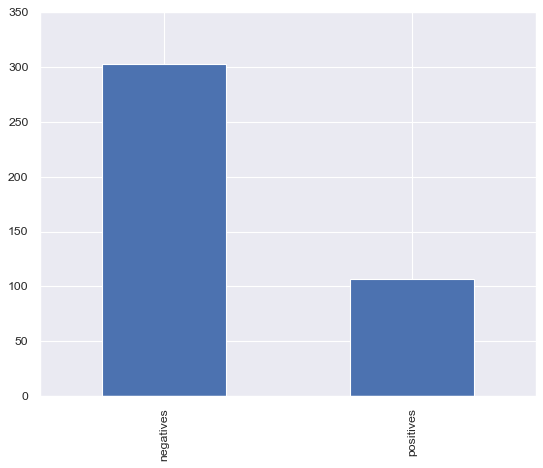

In [13]:
# balanced classes
dataset_df['class'].value_counts().plot(kind='bar')

Visualizing the dataset

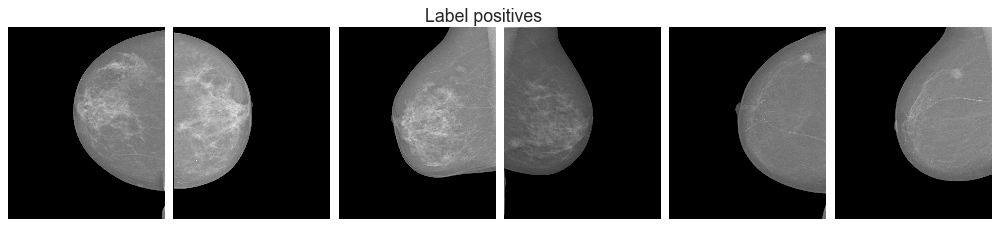

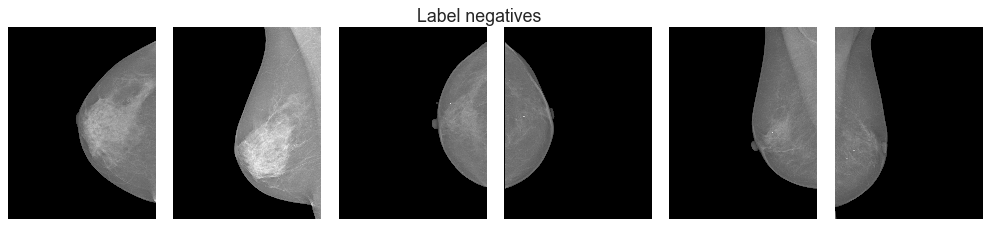

In [15]:
for idx, lbl in enumerate(labels):
    nrows, ncols = 1, 6
    fig, ax = plt.subplots(nrows, ncols, figsize=(16, 3))
    plt.subplots_adjust(wspace=0, hspace=1)

    for idx, fname in enumerate(dataset_df.loc[dataset_df['class'] == lbl]['filename'][:ncols]):
        img = Image.open(os.path.join(dataset_folder_paths[1][1],fname))
        plt.subplot(nrows, ncols, idx+1)
        plt.imshow(np.array(img), cmap='gray')
        fig.suptitle(f'Label {lbl}', fontsize=16)
        plt.axis('off')


## Pre-processing

Pre-processing steps:
1. Image rescaling by a factor of 4
2. The breast profile is pre-segmented using a simple threshold and then the redundant background is cropped away in the dataset.
3. The pixel values in the image are linearly rescaled to 16-bit
4. Contrast limited adaptive histogram equalization (CLAHE) is then applied. The number of tiles in CLAHE is set as {4, 4}, which is arbitrarily chosen, and the contrast enhancement limit is set as 0.01 (default).

Those processes are done firstly on a single image for testing purpsose before modifying the original dataset.

Original Image Shape: (4084, 3328)
Resized Image Shape: (1634, 1331)


(-0.5, 1330.5, 1633.5, -0.5)

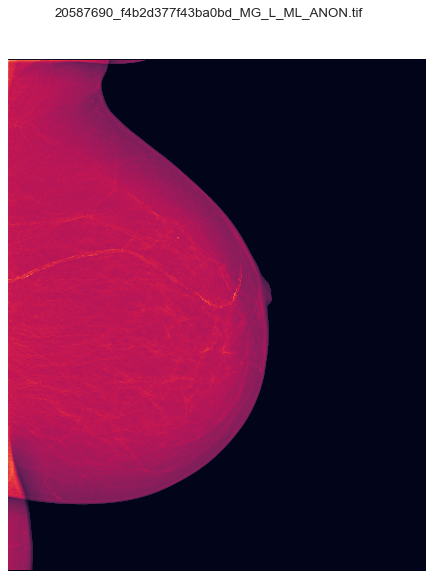

In [119]:
# Reading a single image
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
plt.subplots_adjust(wspace=0, hspace=1)

image_name = os.listdir(
    os.path.join(dataset_folder_paths[1][1])
)[random.randint(0,55)]

# original image
img = cv2.imread(
    os.path.join(dataset_folder_paths[1][1], image_name),
    cv2.IMREAD_UNCHANGED
)
print(f"Original Image Shape: {img.shape}")

# 1. resizing image with a factor of 4 using INTER_CUBIC (bi-cubic) interpolation
scale_factor = 0.4
img_resized = cv2.resize(img, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)
print(f"Resized Image Shape: {img_resized.shape}")


# 2. Pre-segmenting using thresholding technique and cropping redundant background
# https://stackoverflow.com/questions/63575738/remove-letter-artifacts-from-mammography-image
# thresholding_mask = cv2.threshold(gray, 247, 255, cv2.THRESH_BINARY)[1]




# plotting the image
plt.imshow(img_resized)
fig.suptitle(f'{image_name}', fontsize=12)
plt.axis('off')
